# Speech recognition with noise analysis

This notebook implements a speech recognition system with balanced dataset handling and improved model architecture to ensure equal performance across all classes.

## 1. Imports and constants

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Audio, display
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
DATA_PATH = "sound"
WORDS = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
SAMPLE_RATE = 16000
DURATION = 1
N_MELS = 128
FIXED_SHAPE = (128, 32)
TEST_SIZE = 0.2

## 2. Helper functions

In [2]:
def add_white_noise(signal, snr_db):
    """Add white Gaussian noise at a given SNR (dB)"""
    rms_signal = np.sqrt(np.mean(signal**2))
    snr_linear = 10**(snr_db / 10)
    rms_noise = rms_signal / np.sqrt(snr_linear)
    noise = np.random.normal(0, rms_noise, signal.shape)
    return signal + noise

def mix_background_noise(signal, noise, snr_db):
    """Mix background noise at a given SNR (dB)"""
    if len(noise) < len(signal):
        noise = np.tile(noise, int(np.ceil(len(signal) / len(noise))))
    noise = noise[:len(signal)]
    rms_signal = np.sqrt(np.mean(signal**2))
    snr_linear = 10**(snr_db / 10)
    rms_noise = rms_signal / np.sqrt(snr_linear)
    noise = noise / np.sqrt(np.mean(noise**2)) * rms_noise
    return signal + noise

def pad_or_truncate(mel_db, target_shape):
    """Pad or truncate a mel spectrogram to target shape"""
    padded = np.zeros(target_shape)
    h, w = mel_db.shape
    h_target, w_target = target_shape
    h = min(h, h_target)
    w = min(w, w_target)
    padded[:h, :w] = mel_db[:h, :w]
    return padded

def plot_mel_spectrogram(signal, sr, title):
    """Plot mel spectrogram"""
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', vmin=-80, vmax=0)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

## 3. Data loading and preprocessing

In [3]:
# First, check dataset balance
print("Checking dataset distribution:")
samples_per_word = {}
for word in WORDS:
    word_path = os.path.join(DATA_PATH, word)
    if not os.path.exists(word_path):
        print(f"Warning: No folder found for '{word}'")
        continue
    files = [f for f in os.listdir(word_path) if f.endswith('.wav')]
    samples_per_word[word] = len(files)
    print(f"{word}: {len(files)} files")

# Find minimum number of samples across classes for balancing
# min_samples = min(samples_per_word.values())
min_samples = 100  # Set a fixed number for balancing
print(f"\nUsing {min_samples} samples per class for balance")

# Load background noise
bg_noise_path = os.path.join(DATA_PATH, "_background_noise_", "doing_the_dishes.wav")
bg_noise, _ = librosa.load(bg_noise_path, sr=SAMPLE_RATE)

Checking dataset distribution:
yes: 4044 files
no: 3941 files
up: 3723 files
down: 3917 files
left: 3801 files
right: 3778 files
on: 3845 files
off: 3745 files
stop: 3872 files
go: 3880 files

Using 100 samples per class for balance


In [4]:
X = []
y_raw = []
test_files = []

le = LabelEncoder()
le.fit(WORDS)

for word in WORDS:
    word_path = os.path.join(DATA_PATH, word)
    files = [f for f in os.listdir(word_path) if f.endswith('.wav')][:min_samples]  # Take exactly 100 files per word

    signals = []
    labels = []
    paths = []

    for file in files:
        file_path = os.path.join(word_path, file)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        signals.append(signal)
        labels.append(word)
        paths.append(file_path)

    # Split 80/20 train/test
    sig_train, sig_test, lab_train, lab_test, path_train, path_test = train_test_split(
        signals, labels, paths, test_size=0.2, random_state=42, stratify=labels
    )

    # Process training data with augmentation (uncomment if the training will be done with noise)
    for signal in sig_train:
        variants = [
            signal
            # ,
            # add_white_noise(signal, 40),
            # add_white_noise(signal, 20),
            # mix_background_noise(signal, bg_noise, 40),
            # mix_background_noise(signal, bg_noise, 20)
        ]

        for variant in variants:
            mel = librosa.feature.melspectrogram(y=variant, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_fixed = pad_or_truncate(mel_db, FIXED_SHAPE)
            X.append(mel_fixed)
            y_raw.append(word)

    # Save test files
    for p, l in zip(path_test, lab_test):
        test_files.append((p, l))

# Convert to numpy arrays
X = np.array(X)[..., np.newaxis]
y_encoded = le.transform(y_raw)
y = to_categorical(y_encoded)

## 4. Model architecture and training

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 32, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(WORDS), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


c:\Users\manta\Desktop\VU\Magistras\1 kursas\Natūralios kalbos apdorojimas\programinis kodas\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1250 - loss: 11.1460 - val_accuracy: 0.0000e+00 - val_loss: 2.4189
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2278 - loss: 2.1606 - val_accuracy: 0.0000e+00 - val_loss: 5.2474
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3972 - loss: 1.7175 - val_accuracy: 0.0000e+00 - val_loss: 6.1160
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5292 - loss: 1.3740 - val_accuracy: 0.0000e+00 - val_loss: 6.7648
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6014 - loss: 1.1629 - val_accuracy: 0.0000e+00 - val_loss: 6.3697
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6625 - loss: 0.9747 - val_accuracy: 0.0000e+00 - val_loss: 7.8690
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7486 - loss: 0.7528 - val_accuracy: 0.0000e+00 - val_loss: 8.1449
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7653 - loss: 0.6812 - val_ac

## 5. Model evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


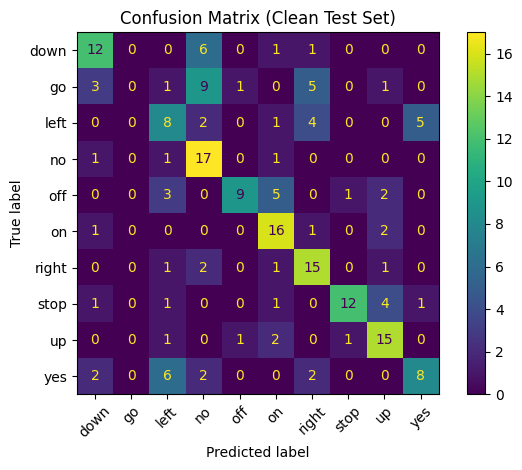

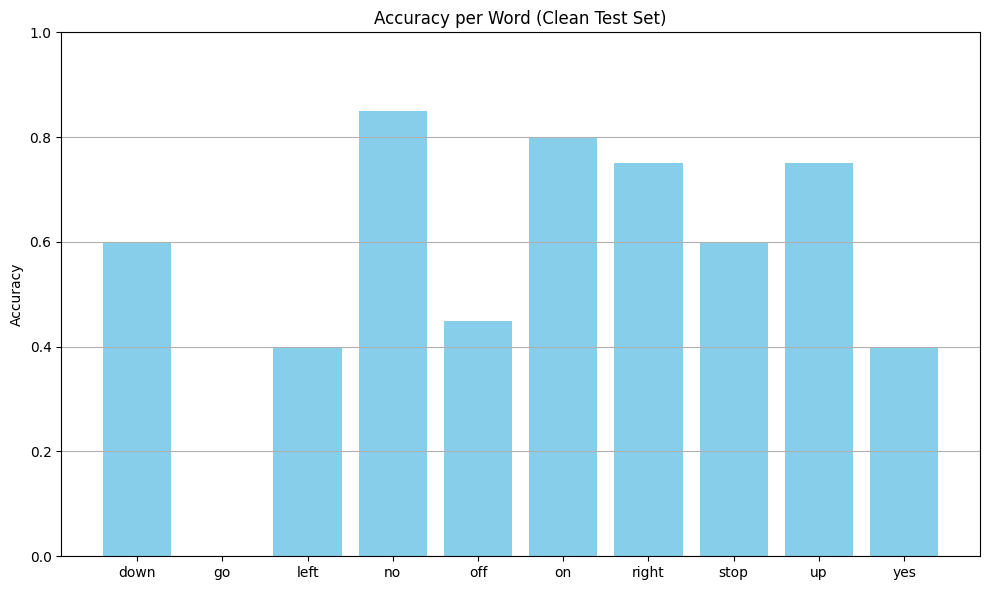

In [6]:
# Prepare test data
X_clean = []
y_clean = []

for file_path, label_str in test_files:
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_fixed = pad_or_truncate(mel_db, FIXED_SHAPE)
    X_clean.append(mel_fixed)
    y_clean.append(label_str)

X_clean = np.array(X_clean)[..., np.newaxis]
y_encoded = le.transform(y_clean)
y_test = to_categorical(y_encoded)

# Make predictions
y_pred_probs = model.predict(X_clean)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix (Clean Test Set)")
plt.tight_layout()
plt.show()

# Calculate and plot per-class accuracy
accuracies = []
for i, word in enumerate(le.classes_):
    idx = np.where(y_true == i)[0]
    acc = accuracy_score(y_true[idx], y_pred[idx])
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.bar(le.classes_, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.title("Accuracy per Word (Clean Test Set)")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 6. Noise analysis

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy on test set (Clean Audio): 0.560


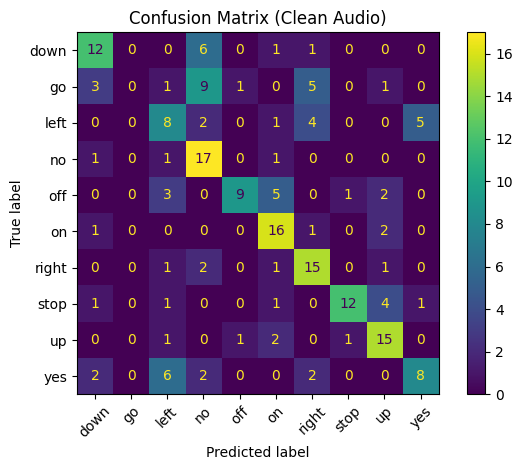

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy on test set (White Noise 40dB): 0.510


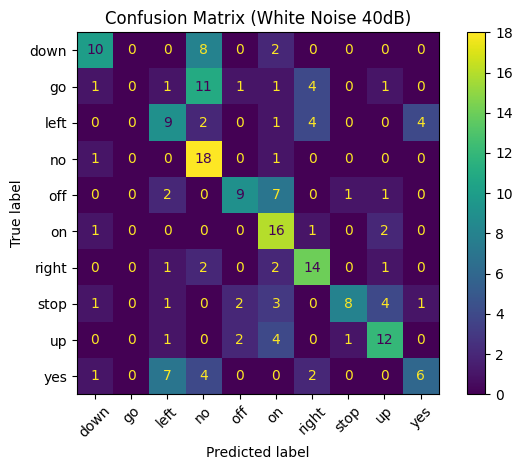

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy on test set (White Noise 20dB): 0.430


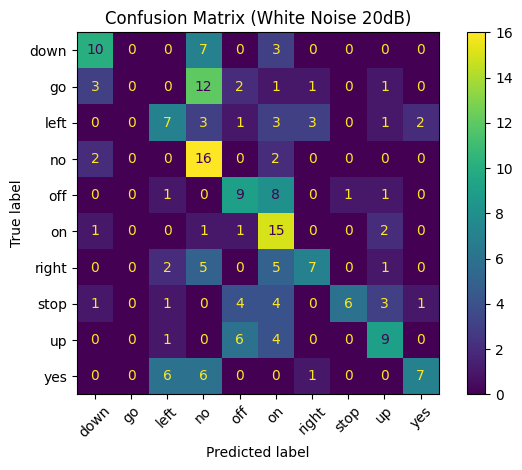

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy on test set (Background Noise 40dB): 0.515


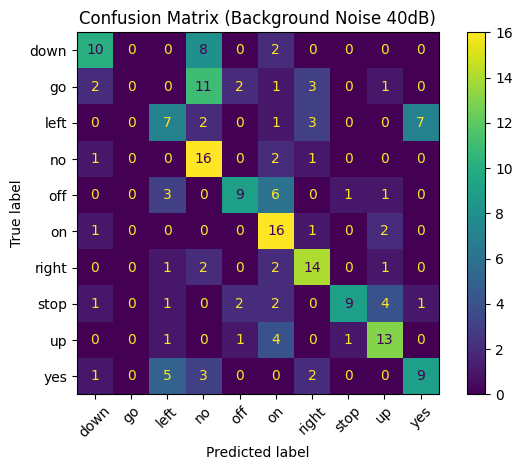

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy on test set (Background Noise 20dB): 0.420


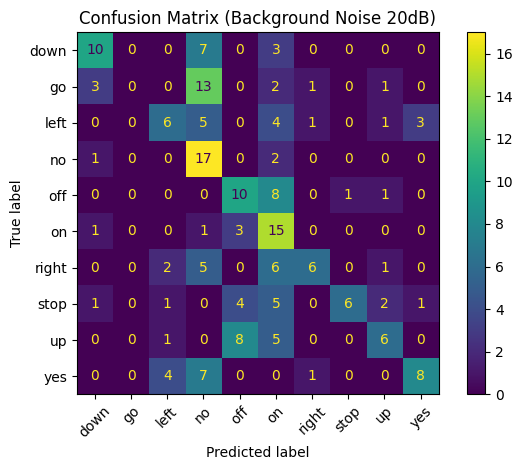

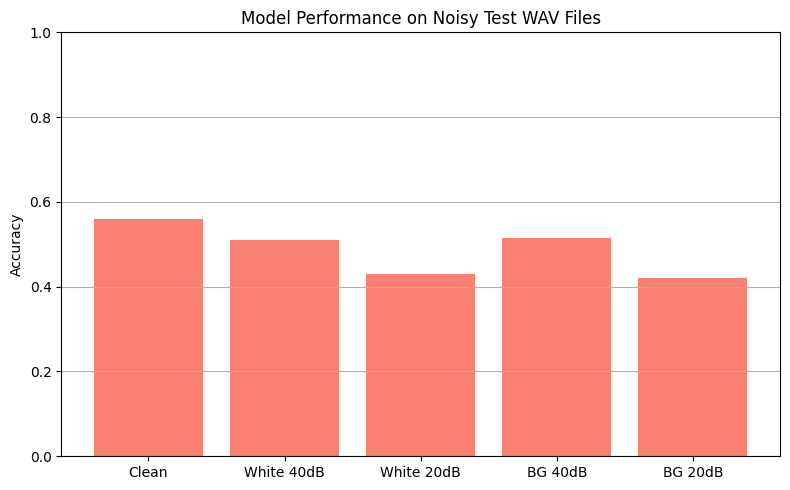

In [7]:
def evaluate_test_files_with_noise(noise_fn, snr_db, label=""):
    X_noise = []
    y_noise = []

    for file_path, label_str in test_files:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        noisy = noise_fn(signal, snr_db)
        mel = librosa.feature.melspectrogram(y=noisy, sr=sr, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_fixed = pad_or_truncate(mel_db, FIXED_SHAPE)
        X_noise.append(mel_fixed)
        y_noise.append(label_str)

    X_noise = np.array(X_noise)[..., np.newaxis]
    y_encoded = le.transform(y_noise)
    y_categorical = to_categorical(y_encoded)

    y_pred_probs = model.predict(X_noise)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_categorical, axis=1)

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy on test set ({label}): {acc:.3f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(xticks_rotation=45)
    plt.title(f"Confusion Matrix ({label})")
    plt.tight_layout()
    plt.show()

    return acc

# Run evaluations
acc_clean = evaluate_test_files_with_noise(lambda x, _: x, 0, "Clean Audio")
acc_white_40 = evaluate_test_files_with_noise(add_white_noise, 40, "White Noise 40dB")
acc_white_20 = evaluate_test_files_with_noise(add_white_noise, 20, "White Noise 20dB")
acc_bg_40 = evaluate_test_files_with_noise(lambda x, snr: mix_background_noise(x, bg_noise, snr), 40, "Background Noise 40dB")
acc_bg_20 = evaluate_test_files_with_noise(lambda x, snr: mix_background_noise(x, bg_noise, snr), 20, "Background Noise 20dB")

noise_labels = ["Clean", "White 40dB", "White 20dB", "BG 40dB", "BG 20dB"]
noise_accuracies = [acc_clean, acc_white_40, acc_white_20, acc_bg_40, acc_bg_20]

plt.figure(figsize=(8, 5))
plt.bar(noise_labels, noise_accuracies, color='salmon')
plt.ylabel("Accuracy")
plt.title("Model Performance on Noisy Test WAV Files")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 7. Audio Examples and Spectrograms

🔊 Original Audio:



🔊 40 dB White Gaussian Noise:



🔊 20 dB White Gaussian Noise:



🔊 40 dB Background Noise (doing_the_dishes.wav):



🔊 20 dB Background Noise (doing_the_dishes.wav):


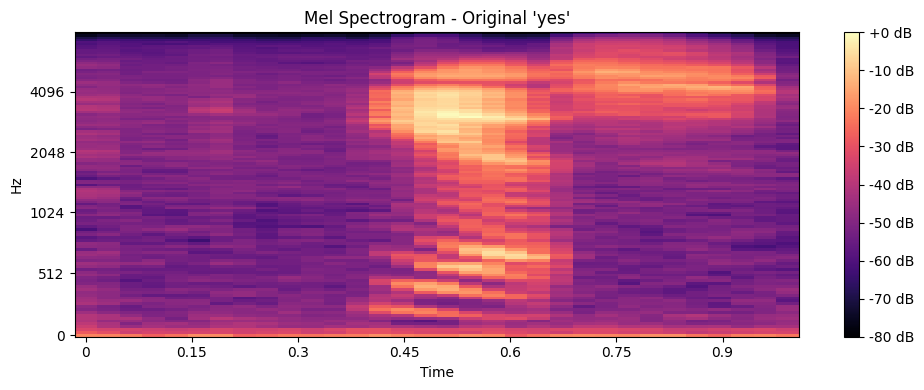

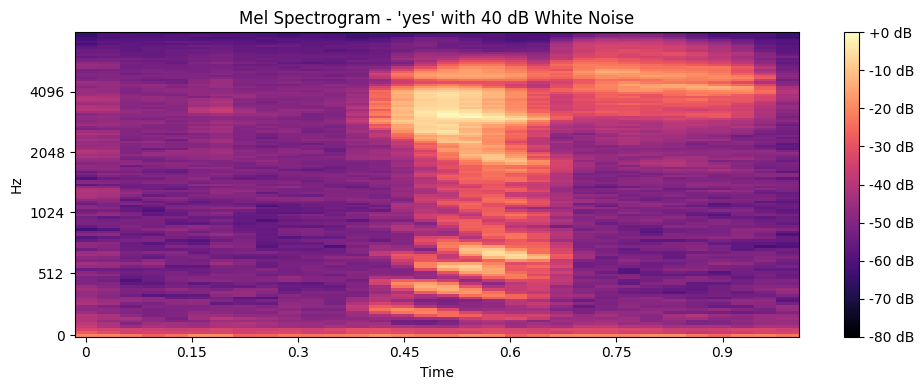

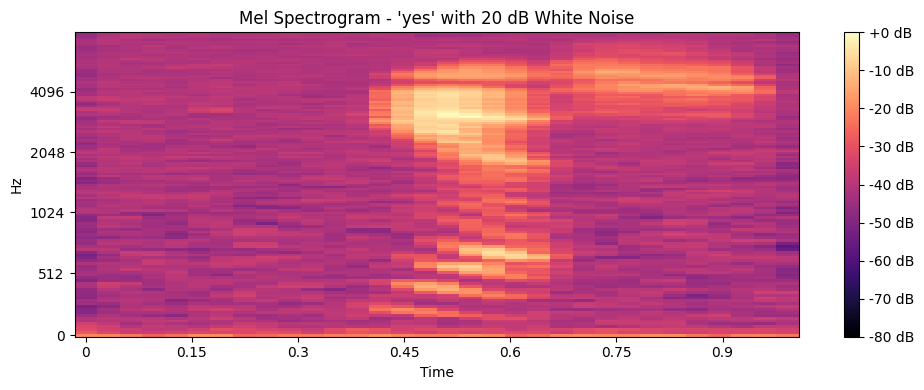

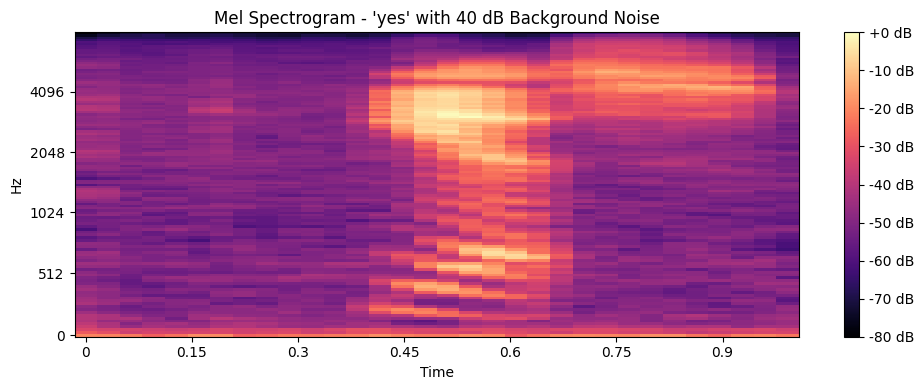

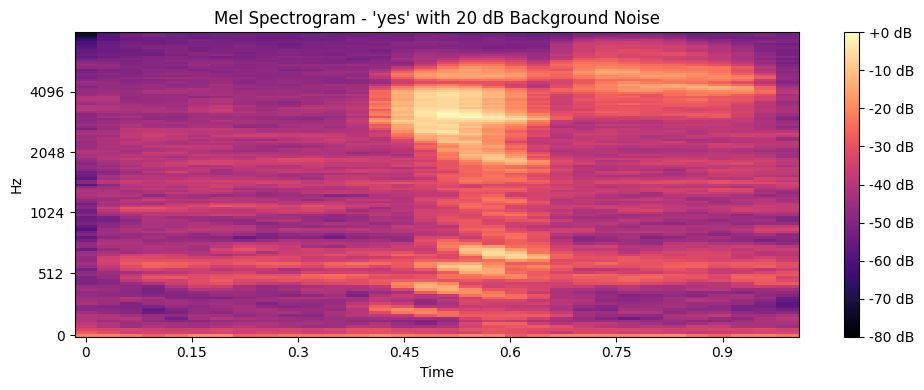

In [8]:
# Load and process example audio
yes_path = os.path.join(DATA_PATH, "yes", os.listdir(os.path.join(DATA_PATH, "yes"))[0])
y_yes, sr = librosa.load(yes_path, sr=SAMPLE_RATE, duration=DURATION)

# Generate noisy versions
y_white_40 = add_white_noise(y_yes, 40)
y_white_20 = add_white_noise(y_yes, 20)
y_bg_40 = mix_background_noise(y_yes, bg_noise, 40)
y_bg_20 = mix_background_noise(y_yes, bg_noise, 20)

# Play audio samples
print("🔊 Original Audio:")
display(Audio(y_yes, rate=sr))

print("\n🔊 40 dB White Gaussian Noise:")
display(Audio(y_white_40, rate=sr))

print("\n🔊 20 dB White Gaussian Noise:")
display(Audio(y_white_20, rate=sr))

print("\n🔊 40 dB Background Noise (doing_the_dishes.wav):")
display(Audio(y_bg_40, rate=sr))

print("\n🔊 20 dB Background Noise (doing_the_dishes.wav):")
display(Audio(y_bg_20, rate=sr))

# Plot spectrograms
plot_mel_spectrogram(y_yes, sr, "Mel Spectrogram - Original 'yes'")
plot_mel_spectrogram(y_white_40, sr, "Mel Spectrogram - 'yes' with 40 dB White Noise")
plot_mel_spectrogram(y_white_20, sr, "Mel Spectrogram - 'yes' with 20 dB White Noise")
plot_mel_spectrogram(y_bg_40, sr, "Mel Spectrogram - 'yes' with 40 dB Background Noise")
plot_mel_spectrogram(y_bg_20, sr, "Mel Spectrogram - 'yes' with 20 dB Background Noise")